## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 17.7 MB/s 
     |████████████████████████████████| 212 kB 67.3 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [5]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels
          

In [6]:
tweets,labels=get_tweet(train)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [9]:
lengths=[len(t.split(' ')) for t in tweets]
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [11]:
padded_train_seq=get_sequences(tokenizer, tweets)

In [12]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [13]:
classes=set(labels)
print(classes)

{'joy', 'sadness', 'fear', 'anger', 'surprise', 'love'}


In [14]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [15]:
class_to_index

{'anger': 3, 'fear': 2, 'joy': 0, 'love': 5, 'sadness': 1, 'surprise': 4}

In [16]:
name_to_ids=lambda labels: np.array([class_to_index.get(x) for x in labels])

In [17]:
train_labels=name_to_ids(labels)
print(train_labels[0])

1


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [19]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [20]:
val_tweets, val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer, val_tweets)
val_labels=name_to_ids(val_labels)

In [21]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [22]:
h=model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]


)

Epoch 1/20
500/500 [==============================] - 19s 17ms/step - loss: 1.3048 - accuracy: 0.4984 - val_loss: 0.9057 - val_accuracy: 0.6685
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.6596 - accuracy: 0.7735 - val_loss: 0.5952 - val_accuracy: 0.8045
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3547 - accuracy: 0.8796 - val_loss: 0.4517 - val_accuracy: 0.8410
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2357 - accuracy: 0.9268 - val_loss: 0.4412 - val_accuracy: 0.8530
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1717 - accuracy: 0.9456 - val_loss: 0.4083 - val_accuracy: 0.8685
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1404 - accuracy: 0.9554 - val_loss: 0.4829 - val_accuracy: 0.8620
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1035 - accuracy: 0.9678 - val_loss: 0.4153 - val_accuracy: 0.879

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

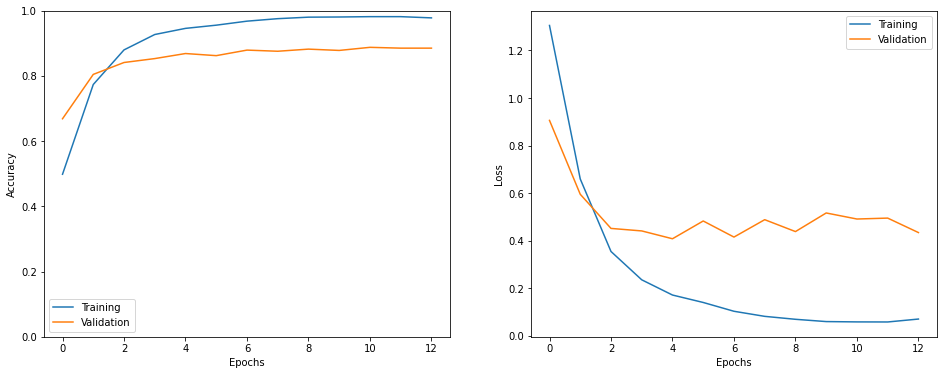

In [23]:
show_history(h)